#**COS30081 FNLP Credit Task**

## **Name: Arthur Vincent Chin**
## **Student ID: 101218817**

In [1]:
# mounting drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. Loading Data and do Exploratory Data Analysis (EDA)** 

In [45]:
import pandas as pd
import seaborn as sns
import re, nltk
nltk.download('punkt')
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from matplotlib import pyplot

import string
from nltk.corpus import stopwords
nltk.download('stopwords')

plt.style.use('fivethirtyeight')
plt.style.use('dark_background')

from sklearn.model_selection import cross_val_score
import numpy as np
!pip install lime
from lime import lime_tabular

from sklearn.ensemble import RandomForestClassifier 

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score # Performance Metrics  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import tensorflow
from tensorflow import keras as keras
from keras.layers import Embedding, LSTM, SimpleRNN, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.preprocessing.text import one_hot, Tokenizer

from keras.layers import Dense, Dropout, Conv1D, Activation, GlobalMaxPooling1D

In [7]:
# read the dataset and show in a table the first 5 contents of the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Credit Task/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
# show unique values of sentiment
df['target'].unique()

array([1, 0])

Total number of sentiments of tweets :
0    4342
1    3271
Name: target, dtype: int64


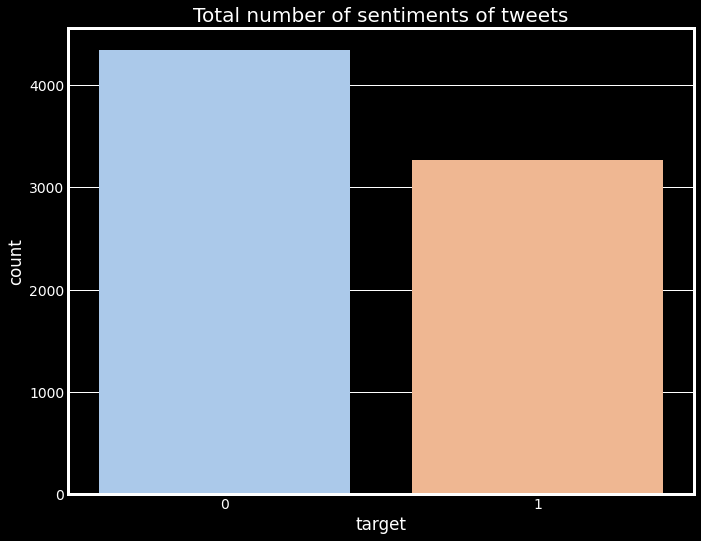

In [12]:
from termcolor import cprint

# plotting a graph to show the total number of sentiments of tweets
cprint("Total number of sentiments of tweets :",'green')
print(df.target.value_counts())
plt.figure(figsize = (10, 8))
ax = sns.countplot(x = 'target', data = df, palette = 'pastel')
ax.set_title(label = 'Total number of sentiments of tweets', fontsize = 20)
plt.show()

## **2. Preprocessing/Cleaning**

In [18]:
# Tokenizing the tweet and also taking tokens from second index onwards as initital to gives airline name and '@' and lowering thm and later making it back a sentence
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens)

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [19]:
df2 = df
df2['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df2.head()

,id,keyword,location,text,target,cleaned_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [23]:
# Cleaning the tweets, removing punctuation marks
df2['cleaned_tweet'] = df2['cleaned_tweet'].apply(text_process)
df2.reset_index(drop=True, inplace = True)
df2.head()

,id,keyword,location,text,target,cleaned_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation orders cal...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfires pou...


## **3. Loading a pretrained Word2Vec model**

In [24]:
# From the nlpia package for downloading data too big for the repo

BIG_URLS = {
    'w2v': (
        'https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1',
        1647046227,
    ),
    'slang': (
        'https://www.dropbox.com/s/43c22018fbfzypd/slang.csv.gz?dl=1',
        117633024,
    ),
    'tweets': (
        'https://www.dropbox.com/s/5gpb43c494mc8p0/tweets.csv.gz?dl=1',
        311725313,
    ),
    'lsa_tweets': (
        'https://www.dropbox.com/s/rpjt0d060t4n1mr/lsa_tweets_5589798_2003588x200.tar.gz?dl=1',
        3112841563,  # 3112841312,
    ),
    'imdb': (
        'https://www.dropbox.com/s/yviic64qv84x73j/aclImdb_v1.tar.gz?dl=1',
        3112841563,  # 3112841312,
    ),
}

In [25]:
!pip install pugnlp

     |████████████████████████████████| 706 kB 22.1 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for pypandoc: filename=pypandoc-1.7.5-py2.py3-none-any.whl size=23503245 sha256=30db4c714479d602458695dd2cb69f87918fcc2d53b05b8e3b3b855879464e87
  Stored in directory: /root/.cache/pip/wheels/df/fc/e9/4e92342cc30e3b25f26f37fca8b9bcd3f847f51a41ed01f122
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149873 sha256=6ac4b39138c6c3240c3c095673354c40298aa0c0d238ae711644fa1c87dbe47a
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built pypandoc python-Levenshtein


In [26]:
import os
import re
import tarfile
import tqdm

import requests

from pugnlp.futil import path_status, find_files

# These functions are part of the nlpia package which can be pip installed and run from there.
def dropbox_basename(url):
    filename = os.path.basename(url)
    match = re.findall(r'\?dl=[0-9]$', filename)
    if match:
        return filename[:-len(match[0])]
    return filename

def download_file(url, data_path='.', filename=None, size=None, chunk_size=4096, verbose=True):
    """Uses stream=True and a reasonable chunk size to be able to download large (GB) files over https"""
    if filename is None:
        filename = dropbox_basename(url)
    file_path = os.path.join(data_path, filename)
    if url.endswith('?dl=0'):
        url = url[:-1] + '1'  # noninteractive download
    if verbose:
        tqdm_prog = tqdm
        print('requesting URL: {}'.format(url))
    else:
        tqdm_prog = no_tqdm
    r = requests.get(url, stream=True, allow_redirects=True)
    size = r.headers.get('Content-Length', None) if size is None else size
    print('remote size: {}'.format(size))

    stat = path_status(file_path)
    print('local size: {}'.format(stat.get('size', None)))
    if stat['type'] == 'file' and stat['size'] == size:  # TODO: check md5 or get the right size of remote file
        r.close()
        return file_path

    print('Downloading to {}'.format(file_path))

    with open(file_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=chunk_size):
            if chunk:  # filter out keep-alive chunks
                f.write(chunk)

    r.close()
    return file_path

def untar(fname):
    if fname.endswith("tar.gz"):
        with tarfile.open(fname) as tf:
            tf.extractall()
    else:
        print("Not a tar.gz file: {}".format(fname))

/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
/usr/local/lib/python3.7/dist-packages/pugnlp/constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')


In [27]:
download_file(BIG_URLS['w2v'][0])

requesting URL: https://www.dropbox.com/s/965dir4dje0hfi4/GoogleNews-vectors-negative300.bin.gz?dl=1
remote size: 1647046227
local size: None


'./GoogleNews-vectors-negative300.bin.gz'

In [28]:
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True, limit=200000)

In [29]:
df2.shape

(7613, 6)

In [30]:
data = df2[['text','target']]
data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [31]:
def clean_train_data(x):
    text = x
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\n', '', text)
    return text

In [32]:
data['text'] = data.text.apply(lambda x : clean_train_data(x))
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in...,1
4,just got sent this photo from ruby alaska as s...,1


## **4. Building and Compiling a CNN model**

In [33]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

In [34]:
X.shape

(7613, 30)

In [36]:
# add layers such as embedding, spatial dropout, LSTM, and a dense layer with 2 for the classes positive and negative
# with an activation layer using softmax and a loss function of categorical crossentropy using the adam optimizer
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 128)           256000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 30, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________


In [37]:
Y = pd.get_dummies(data['target']).values

In [39]:
# train test split with a test size of 0.33
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

In [40]:
# set batch size and train for a minimum of 5 epochs
batch_size = 32 # set batch size to 32 (number can change when hyper tuning)
history = model.fit(X_train, y_train, epochs=5, batch_size=batch_size, verbose=2)

Epoch 1/5
160/160 - 28s - loss: 0.5636 - accuracy: 0.7055 - 28s/epoch - 177ms/step
Epoch 2/5
160/160 - 24s - loss: 0.4025 - accuracy: 0.8251 - 24s/epoch - 147ms/step
Epoch 3/5
160/160 - 23s - loss: 0.3561 - accuracy: 0.8439 - 23s/epoch - 146ms/step
Epoch 4/5
160/160 - 25s - loss: 0.3115 - accuracy: 0.8698 - 25s/epoch - 157ms/step
Epoch 5/5
160/160 - 26s - loss: 0.2806 - accuracy: 0.8810 - 26s/epoch - 160ms/step


In [41]:
# evaluate model performance
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('score', score)
print('accuracy', acc)

79/79 - 2s - loss: 0.5346 - accuracy: 0.7895 - 2s/epoch - 24ms/step
score 0.5345751643180847
accuracy 0.7894946336746216


In [43]:
# using random forest to evaluate model
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [44]:
rf_prediction =  rf.predict(X_test)

In [46]:
accuracy_score(rf_prediction,y_test)

0.6466374850775966

In [47]:
# Visualize model's performance
cr = classification_report(y_test, rf_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.66      0.80      0.72      1446
           1       0.63      0.45      0.52      1067

   micro avg       0.65      0.65      0.65      2513
   macro avg       0.65      0.62      0.62      2513
weighted avg       0.65      0.65      0.64      2513
 samples avg       0.65      0.65      0.65      2513



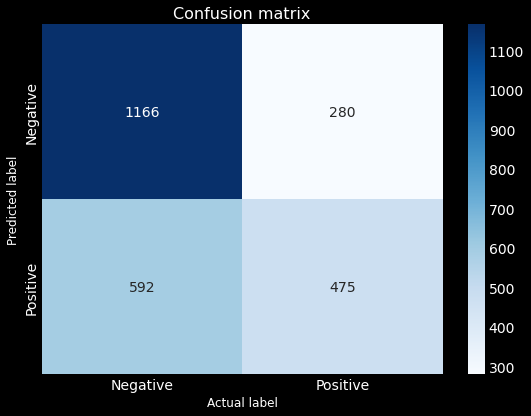

In [52]:
print("Classification Report:\n----------------------\n", cr)

cm = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(rf_prediction, axis=1))


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

## **5. Improving Model**

In [84]:
# add layers such as embedding, spatial dropout, LSTM, and a dense layer with 2 for the classes positive and negative
# with an activation layer using softmax and a loss function of categorical crossentropy using the adam optimizer
embed_dim = 256
lstm_out = 196

model_improved = Sequential()
model_improved.add(Embedding(max_features, embed_dim, input_length = X.shape[1]))
model_improved.add(SpatialDropout1D(0.4))
model_improved.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_improved.add(Dense(2, activation='softmax'))
model_improved.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

model_improved.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 30, 256)           512000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 30, 256)          0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 196)               355152    
                                                                 
 dense_7 (Dense)             (None, 2)                 394       
                                                                 
Total params: 867,546
Trainable params: 867,546
Non-trainable params: 0
_________________________________________________________________


In [85]:
# retrain the model this time with 10 epochs instead
batch_size = 32
history = model_improved.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=2)

Epoch 1/10
160/160 - 73s - loss: 0.5594 - accuracy: 0.7178 - 73s/epoch - 455ms/step
Epoch 2/10
160/160 - 29s - loss: 0.4116 - accuracy: 0.8171 - 29s/epoch - 182ms/step
Epoch 3/10
160/160 - 30s - loss: 0.3572 - accuracy: 0.8427 - 30s/epoch - 187ms/step
Epoch 4/10
160/160 - 29s - loss: 0.3136 - accuracy: 0.8639 - 29s/epoch - 183ms/step
Epoch 5/10
160/160 - 30s - loss: 0.2808 - accuracy: 0.8829 - 30s/epoch - 189ms/step
Epoch 6/10
160/160 - 30s - loss: 0.2488 - accuracy: 0.8998 - 30s/epoch - 185ms/step
Epoch 7/10
160/160 - 29s - loss: 0.2153 - accuracy: 0.9116 - 29s/epoch - 184ms/step
Epoch 8/10
160/160 - 29s - loss: 0.1921 - accuracy: 0.9200 - 29s/epoch - 182ms/step
Epoch 9/10
160/160 - 31s - loss: 0.1718 - accuracy: 0.9259 - 31s/epoch - 191ms/step
Epoch 10/10
160/160 - 29s - loss: 0.1555 - accuracy: 0.9390 - 29s/epoch - 183ms/step


In [86]:
# evaluate model performance
score, acc = model_improved.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)
print('score', score)
print('accuracy', acc)

79/79 - 2s - loss: 0.8050 - accuracy: 0.7696 - 2s/epoch - 30ms/step
score 0.8049559593200684
accuracy 0.7695980668067932


In [87]:
# using random forest to evaluate model
rf2 = RandomForestClassifier()
rf2.fit(X_train,y_train)

RandomForestClassifier()

In [88]:
rf2_prediction =  rf2.predict(X_test)

In [89]:
accuracy_score(rf2_prediction,y_test)

0.658575407879029

In [90]:
# Visualize model's performance
cr2 = classification_report(y_test, rf2_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.67      0.81      0.73      1446
           1       0.65      0.46      0.54      1067

   micro avg       0.67      0.66      0.66      2513
   macro avg       0.66      0.63      0.64      2513
weighted avg       0.66      0.66      0.65      2513
 samples avg       0.66      0.66      0.66      2513



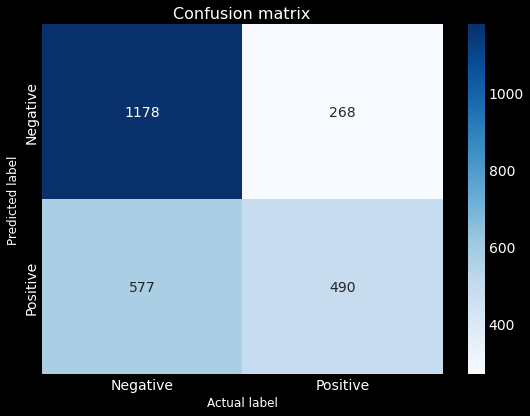

In [91]:
print("Classification Report:\n----------------------\n", cr2)

cm = confusion_matrix(np.argmax(np.array(y_test), axis=1), np.argmax(rf2_prediction, axis=1))


# plot confusion matrix 
plt.figure(figsize=(8,6))
sentiment_classes = ['Negative', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
            xticklabels=sentiment_classes,
            yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()

## **6. Testing model on real-world tweets**

In [106]:
# link to tweet: https://twitter.com/GondaiMutongi/status/1514551081916895233

text1 = ['''Sad images of flooding in Durban South Africa. Opposition 
parties in South Africa are not blaming Government for this natural disaster.
If it was Zimbabwe, Hopewell and Chamisa will be shouting to the world saying 
the floods were caused by corruption. We have a cursed opposition''']
text1 = token.texts_to_sequences(text1)
text1 = pad_sequences(text1, maxlen=30, dtype='int32', value=0)
res = model_improved.predict(text1, batch_size=1,verbose = 2)
res

1/1 - 0s - 35ms/epoch - 35ms/step


array([[0.00155046, 0.99844956]], dtype=float32)

In [107]:
if np.argmax(res[0]) == 0:
    print("Non-natural Disaster Tweet")
elif np.argmax(res[0]) == 1:
    print("Natural Disaster Tweet")

Natural Disaster Tweet


In [108]:
# link to tweet: https://twitter.com/nytimes/status/1515276344212570117

text2 = ['''Tonga's underwater volcano eruption spawned a tsunami that 
devastated many of its islands and struck far-off shores. Watch this 
simulation to see how it generated a shockwave in the atmosphere that 
scientists hadn't seen in more than half a century.''']
text2 = token.texts_to_sequences(text2)
text2 = pad_sequences(text2, maxlen=30, dtype='int32', value=0)
res = model_improved.predict(text2, batch_size=1,verbose = 2)
res

1/1 - 0s - 58ms/epoch - 58ms/step


array([[0.00738413, 0.99261594]], dtype=float32)

In [109]:
if np.argmax(res[0]) == 0:
    print("Non-natural Disaster Tweet")
elif np.argmax(res[0]) == 1:
    print("Natural Disaster Tweet")

Natural Disaster Tweet


In [110]:
# link to tweet: https://twitter.com/thepainterflynn/status/1514624683399913475

text3 = ['''Today in 1999 a severe hailstorm strikes Sydney, Australia 
causing A$2.3 billion in insured damages, the most costly natural disaster 
in Australian history.''']
text3 = token.texts_to_sequences(text3)
text3 = pad_sequences(text3, maxlen=30, dtype='int32', value=0)
res = model_improved.predict(text3, batch_size=1,verbose = 2)
res

1/1 - 0s - 51ms/epoch - 51ms/step


array([[4.0637959e-05, 9.9995935e-01]], dtype=float32)

In [111]:
if np.argmax(res[0]) == 0:
    print("Non-natural Disaster Tweet")
elif np.argmax(res[0]) == 1:
    print("Natural Disaster Tweet")

Natural Disaster Tweet


In [112]:
# link to tweet: https://twitter.com/easerhythm/status/1515094585504108547

text4 = ['''Kmedia now called BIGBANG as "EMPERORS OF KPOP".  In terms: 
an emperor is above all kings, are the lord and master of an empire and 
empires are made up of many kingdoms. So this is the highest noble title. 
It's considered celestial and sacred.
THIS IS BIGBANG NOW? bcs i love it!''']
text4 = token.texts_to_sequences(text4)
text4 = pad_sequences(text4, maxlen=30, dtype='int32', value=0)
res = model_improved.predict(text4, batch_size=1,verbose = 2)
res

1/1 - 0s - 56ms/epoch - 56ms/step


array([[0.9959061 , 0.00409388]], dtype=float32)

In [113]:
if np.argmax(res[0]) == 0:
    print("Non-natural Disaster Tweet")
elif np.argmax(res[0]) == 1:
    print("Natural Disaster Tweet")

Non-natural Disaster Tweet


In [114]:
# link to tweet: https://twitter.com/elonmusk/status/1510510978286428163

text5 = ['''I am inspired by curiosity. That is what drives me. So let us 
expand the scope & scale of consciousness so that we may aspire to 
understand the Universe.''']
text5 = token.texts_to_sequences(text5)
text5 = pad_sequences(text5, maxlen=30, dtype='int32', value=0)
res = model_improved.predict(text5, batch_size=1,verbose = 2)
res

1/1 - 0s - 45ms/epoch - 45ms/step


array([[9.9962640e-01, 3.7359807e-04]], dtype=float32)

In [115]:
if np.argmax(res[0]) == 0:
    print("Non-natural Disaster Tweet")
elif np.argmax(res[0]) == 1:
    print("Natural Disaster Tweet")

Non-natural Disaster Tweet


In [116]:
# link to tweet: https://twitter.com/88rising/status/1515358217890525185

text6 = ['''10 hours away...live from the MainStage at @coachella! You rocking 
with the most fly Asians. Head in the Clouds Forever. Watch it live on YouTube 
channel 1. 6:45 pm pst! See you soon, and thank you for all the encouragement, 
love and support. We hope to make you proud!''']
text6 = token.texts_to_sequences(text6)
text6 = pad_sequences(text6, maxlen=30, dtype='int32', value=0)
res = model_improved.predict(text6, batch_size=1,verbose = 2)
res

1/1 - 0s - 54ms/epoch - 54ms/step


array([[0.99892753, 0.00107241]], dtype=float32)

In [117]:
if np.argmax(res[0]) == 0:
    print("Non-natural Disaster Tweet")
elif np.argmax(res[0]) == 1:
    print("Natural Disaster Tweet")

Non-natural Disaster Tweet


## **7. Save model and weights**

In [118]:
# save 1st model and weights
model.save('/content/drive/MyDrive/Colab Notebooks/Credit Task/cnn_model.h5')
model.save_weights('/content/drive/MyDrive/Colab Notebooks/Credit Task/cnn_model_weights.h5')

In [119]:
# save improved model and weights
model_improved.save('/content/drive/MyDrive/Colab Notebooks/Credit Task/cnn_model_improved.h5')
model_improved.save_weights('/content/drive/MyDrive/Colab Notebooks/Credit Task/cnn_model_improved_weights.h5')